# Explore MIMIC-III Dataset
### Author: Kevin Dick

This Notebook is used to explore the MIMIC-III dataset and captures assumptions made for the ICD-9 Prediction Project.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Set the Matplotlib to use inline plots
plt.style.use('ggplot')

# Set the database connection information
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [17]:
# Investigate the distributions of dates to look at sequentiality...

# First find a few cases with multiple admissions
query = query_schema + """
SELECT subject_id, COUNT(subject_id) AS num_vistis
FROM admissions
GROUP BY subject_id
"""
df = pd.read_sql_query(query, con)
df.head(10)

,subject_id,num_vistis
0,10295,1
1,11890,1
2,22262,1
3,6122,1
4,65130,1
5,12267,2
6,23772,1
7,28365,3
8,8533,3
9,12377,1


In [22]:
# Selecting the patients with subject_id 8533 and 283665 to query the sequentiality of their dates
query = query_schema + """
SELECT chartdate
FROM noteevents
WHERE subject_id = 28365
"""
df = pd.read_sql_query(query, con)
df.head()

,chartdate
0,2187-11-07
1,2190-01-08
2,2192-06-22
3,2190-01-05
4,2190-01-05


## Dates are Internally Consistent!
Our experimental design should ensure that all patients have at **least two admissions** (to limit the num of subject ids). Of these admissions, we need to **determine the LAST admission date** on a per-patient basis for our hold-out test. The remaining data is used for training. This is a more appropriate splitting of data since it operates on a per-patient basis, as opposed to the selection of a static split-point.


In [50]:
# Lets produce a plot of the distribution of admissions of two or greater before moving forward...
query = query_schema + """
SELECT subject_id, num_visits
    FROM (SELECT subject_id, COUNT(subject_id) AS num_visits
        FROM admissions
        GROUP BY subject_id) AS count_table
    WHERE num_visits > 0
"""
df = pd.read_sql_query(query, con)

import plotly
plotly.tools.set_credentials_file(username='chasingtheinfinite', api_key='Bmxrkfjwkbf4jHbI71Fo')
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Histogram(x=df.num_visits, xbins=dict(start=2, size=1, end=np.max(df.num_visits)),marker=dict(color='rgb(0, 0, 100)'))
layout = go.Layout(title="Histogram of the Frequency of Hospital Admissions", 
                   xaxis=dict(title="Number of Admissions"), 
                   yaxis=dict(title="Frequency"))
fig = go.Figure(data=go.Data([trace]), layout=layout)
py.iplot(fig, filename='histogram-num-visits')

### Previously Considered: Limit to only patients with 2 or more ADMISSIONS
This code snippet was the query used to accomplish that extraction:

```
query = query_schema + """
SELECT fusion_table.subject_id, fusion_table.chartdate, fusion_table.text
FROM (
    SELECT subject_id, num_visits
    FROM (SELECT subject_id, COUNT(subject_id) AS num_visits
        FROM admissions
        GROUP BY subject_id) AS count_table
    WHERE num_visits > 1) AS visit_table
JOIN noteevents AS fusion_table ON visit_table.subject_id = fusion_table.subject_id 
"""
```

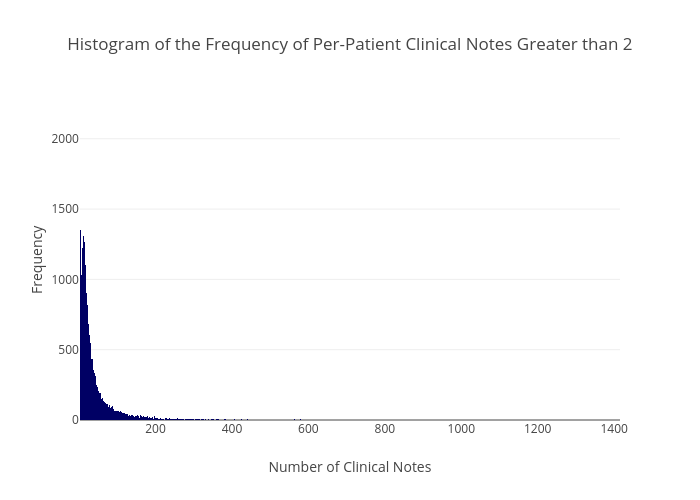

In [84]:
# Lets produce a plot of the distribution of CLINICAL NOTES of two or greater before moving forward...
query = query_schema + """
SELECT subject_id, num_clinotes
    FROM (SELECT subject_id, COUNT(subject_id) AS num_clinotes
        FROM noteevents
        GROUP BY subject_id) AS count_table
    WHERE num_clinotes > 1
"""
df = pd.read_sql_query(query, con)

import plotly
plotly.tools.set_credentials_file(username='chasingtheinfinite', api_key='Bmxrkfjwkbf4jHbI71Fo')
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Histogram(x=df.num_clinotes, xbins=dict(start=2, size=1, end=np.max(df.num_clinotes)),marker=dict(color='rgb(0, 0, 100)'))
layout = go.Layout(title="Histogram of the Frequency of Per-Patient Clinical Notes Greater than 2", 
                   xaxis=dict(title="Number of Clinical Notes"), 
                   yaxis=dict(title="Frequency"))
fig = go.Figure(data=go.Data([trace]), layout=layout)
py.image.ishow(fig) # TOO MANY POINTS! Return the image instead!
#py.iplot(fig, filename='histogram-num-visits')

In [85]:
# Make fancy query to pull thr clinical notes of only patients with two or more clinical notes

# Count number of times subject_id appears in the noteevents table (indicates number of unique notes)
# 
query = query_schema + """
SELECT fusion_table.subject_id, fusion_table.chartdate, fusion_table.hadm_id, fusion_table.text
FROM (
    SELECT subject_id, num_clinotes
    FROM (SELECT subject_id, COUNT(subject_id) AS num_clinotes
        FROM noteevents
        GROUP BY subject_id) AS count_table
    WHERE num_clinotes > 1) AS clinotes_table
JOIN noteevents AS fusion_table ON clinotes_table.subject_id = fusion_table.subject_id 
"""
df = pd.read_sql_query(query, con)
df.head(10)

,subject_id,chartdate,text
0,28365,2187-11-07,"Discharge Note.\npt. admited with hypothermia,..."
1,28365,2187-11-07,"Nursing 0200-0700:\n\n47 year old male, Full C..."
2,28365,2192-06-20,[**2192-6-20**] 4:05 PM\n CTA CHEST W&W/O C&RE...
3,28365,2192-06-20,[**2192-6-20**] 4:04 PM\n CT C-SPINE W/O CONTR...
4,28365,2192-06-20,[**2192-6-20**] 4:04 PM\n CT HEAD W/O CONTRAST...
5,28365,2192-06-20,[**2192-6-20**] 3:04 PM\n CHEST (PORTABLE AP) ...
6,28365,2190-01-07,[**2190-1-7**] 3:15 PM\n CHEST (PA & LAT) ...
7,28365,2190-01-05,[**2190-1-5**] 6:51 PM\n CHEST (PORTABLE AP) ...
8,28365,2187-11-06,[**2187-11-6**] 7:30 PM\n CHEST (PA & LAT) ...
9,28365,2190-01-06,TITLE:\n Chief Complaint:\n HPI:\n 49 yo...


In [45]:
# Sort the subject_id column to group together the date, and then internally sort the dates for each patient...
sorted_df = df.sort_values(['subject_id', 'chartdate'], ascending=[True, True])
sorted_df.head(20)

,subject_id,chartdate,text
508276,17,2134-12-22,Normal sinus rhythm. Tracing is within normal ...
508275,17,2134-12-27,OP DAY MINIMALLY INVASIVE PFO REPAIR\nNSR. NO ...
508277,17,2134-12-27,Sinus rhythm. Normal ECG. Since the previous t...
508271,17,2134-12-28,CSRU NURSING PROGRESS NOTE 0700-1900\nCARDIAC-...
508272,17,2134-12-28,replaced K+ of 3.8 with 20 MEQ KCL IVPB\n
508273,17,2134-12-28,"Neuro: A&O X3,C/O incisional pain X1, medicate..."
508270,17,2134-12-29,"NEURO: ALERT AND ORIENTED TO TIME, PLACE AND ..."
508297,17,2134-12-31,Admission Date: [**2134-12-27**] ...
508278,17,2135-04-26,"Sinus tachycardia. Otherwise, normal ECG. Sinc..."
508279,17,2135-04-26,"Sinus tachycardia. Otherwise, normal ECG. Sinc..."


## Experimental Design

We have conserved the clinical notes of only those patients with two or more visits. Given the sorted dataframe of subject_id and datetimes relative to the clinical notes, we can appropriately divide this dataset into a training and test set on a per-patient basis.

---

We  will now divide the dataset into a training and testing dataset. We differentitate the test set from the training set as the LAST record in the EHR. This  ensure that the clinical note is the most *future* record in the dataset. This same approach is employed accross this study. We use the latest temporal record on a within-subject basis to ensure we predict the future diagnoses of that patient rather than performing simple recall.

In [79]:
# Generate the Training set by removing the last record from each subject within their group of notes
train_df = pd.DataFrame(columns=['subject_id', 'chartdate', 'hadm_id', 'text'])
test_df = pd.DataFrame(columns=['subject_id', 'chartdate', 'hadm_id', 'text'])

# Create array of all unique subject_ids
subjects = sorted_df.subject_id.unique()
print 'Number of Subjects: ' + str(len(subjects))

# Iterate over all subjects and get their grouped data in the sorted_df
for subject in subjects:
    group = sorted_df.loc[sorted_df['subject_id'] == subject]
    last_hadm = group.tail(1)['hadm_id']
    
    # Create variable with TRUE is hadm_id is the last one; create a second is NOT last visit
    last_visit = group['hadm_id'] == last_hadm
    not_last   = group['hadm_id'] != last_hadm
    
    # Put the data related to the LAST VISIT into the test set
    test_df = pd.concat([test_df, group[last_visit]])
    
    # Remaining get appended to the training set
    train_df = pd.concat([train_df, group[not_last]])

print "Training Set Size: " + str(len(train_df))
print "Testing Set Size: " + str(len(test_df))


Number of Subjects: 7535
Training Set Size: 731592
Testing Set Size: 7535


In [66]:
# Determine the average number of clinical notes per patient...
# This will help us determine the number of clinical notes to subsample when creating the LDA topic model!
query = query_schema + """
SELECT subject_id, text
FROM noteevents
"""
df = pd.read_sql_query(query, con)
total_notes = len(df)

query = query_schema + """
SELECT subject_id, COUNT(subject_id) AS occurences
FROM noteevents
GROUP BY subject_id
"""
df = pd.read_sql_query(query, con)
avg_notes = df["occurences"].mean()
subsample_size = total_notes / avg_notes
print 'Average number of Clinical Notes per Patient: ' + str(avg_notes)
print 'Approximation of Minimum Subsample Size: ' + str(subsample_size)
df.head()

KeyboardInterrupt: 

## Sanity Check: 
### Estimated Subsample Must be in Agreement with Number of Patients

By counting the number of unique patients, we can ensure that the subsample number is in agreement with the total number of patients. In determining the average number of clinical notes and dividing it from the total number of notes, we should reconstruct the patient number. 

We can likely move forward with ~100,000 as our subsample which equates to ~2 clinical notes per patient to test and train our LDA model over.

In [4]:
# Lets count all the unique patient IDs available
query = query_schema + """
SELECT subject_id
FROM icustays
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id
0,268
1,269
2,270
3,271
4,272


In [5]:
unique = df.groupby('subject_id').nunique()
print "Number of Subjects: " + str(len(df))
print "Number of Unique  : "
print unique.describe()

Number of Subjects: 61532
Number of Unique  : 
       subject_id
count     46476.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0


### Total number of Unique Patients: 46,476
This comprises **38,596 distinct adults** and **7,870 neonates**

For the purposes of this study, we will remove neonates and develop a classifier suitable to the prediction adult ICD9 codes. This will be achieved by enforcing 

In [6]:
# Next lets find the vocabulary of all ICD-9 Code
query = query_schema + """
SELECT subject_id, icd9_code
FROM diagnoses_icd
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,icd9_code
0,109,40301
1,109,486
2,109,58281
3,109,5855
4,109,4254


In [7]:
icd9_num = len(df.icd9_code.unique())
print "The number of unique ICD-9 Codes with a Patient: " + str(icd9_num)

The number of unique ICD-9 Codes with a Patient: 6985


### Total number of Unique ICD-9 Codes with at Least One Diagnosed Patient: 6,985


In [8]:
# Count the number of Occurences of each ICD-9 Code 
query = query_schema + """
SELECT icd9_code, COUNT(*)
FROM diagnoses_icd
GRouP BY icd9_code
"""
df = pd.read_sql_query(query, con)
df.head()

,icd9_code,count
0,None,47
1,2538,12
2,69012,1
3,82100,14
4,E8694,1


In [9]:
# Lets Count the Number of Unique Procedures to use as headers in our Raw Matrix...
query = query_schema + """
SELECT icd9_code
FROM procedures_icd
"""
df = pd.read_sql_query(query, con)
df.head()
print "Number of unique Procedure Codes: " + str(len(df.icd9_code.unique()))

Number of unique Procedure Codes: 2032


In [11]:
# Lets Count the Number of Unique Procedures to use as headers in our Raw Matrix...
query = query_schema + """
SELECT drug
FROM prescriptions
"""
df = pd.read_sql_query(query, con)
df.head()
print "Number of unique Prescriptions Codes: " + str(len(df.drug.unique()))

Number of unique Prescriptions Codes: 4525


In [22]:
#Some Serious Plotting Meow... Move this to top eventually.....
import plotly
plotly.tools.set_credentials_file(username='chasingtheinfinite', api_key='Bmxrkfjwkbf4jHbI71Fo')
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff


# Create a Simple Histogra based on the counts
#data = [Bar(x = df.icd9_code,
#            y = df.count)]
#py.iplot(data, filename = 'jupyter/icd9_histogram')
#df.iplot(kind = 'histogram', filename = 'jupyter/icd9_histogram')
data = [go.Histogram(x = df['count'],
                     name = 'ICD9 Counts',
                     text = df['icd9_code'])]

layout = go.Layout(title = 'Histogram of ICD9 Counts',
                   xaxis = dict(title = 'ICD9 Code'),
                   yaxis = dict(title = 'Counts'))

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'pandas/simple-histogram')

In [ ]:
# Given the sparcity of diagnoses, we definitely need to generalise these codes.
